2501985451- Jason Adriel

#0. Prerequisites

In [1]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Superglobals
GLOBAL_SEED = 2307
WINDOW_SIZE = 5
HORIZON = 1

# Seeding
keras.utils.set_random_seed(GLOBAL_SEED)

# Setup
sns.set_style('whitegrid')

In [2]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=a0247b643d58102d4e60f9bcdc7d5b47a710969dbf5f6814584363d99c4f7496
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [3]:
!wget "https://media.githubusercontent.com/media/subtle64/Datasets/main/Others/X.csv" -O "X.csv"

--2024-01-23 04:08:05--  https://media.githubusercontent.com/media/subtle64/Datasets/main/Others/X.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293495 (287K) [text/plain]
Saving to: ‘X.csv’

X.csv               100%[===================>] 286.62K  --.-KB/s    in 0.1s    

2024-01-23 04:08:06 (2.53 MB/s) - ‘X.csv’ saved [293495/293495]



#1. Data Exploration

In [4]:
df = pd.read_csv("X.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3808 non-null   object 
 1   Open       3807 non-null   float64
 2   High       3807 non-null   float64
 3   Low        3807 non-null   float64
 4   Close      3807 non-null   float64
 5   Adj Close  3807 non-null   float64
 6   Volume     3807 non-null   float64
dtypes: float64(6), object(1)
memory usage: 208.4+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3.807000e+03
mean,1207.953241,1230.793315,1185.663883,1207.159945,1047.459832,6.858102e+07
std,664.882117,679.635933,649.243280,665.202070,495.685067,1.308133e+08
min,290.000000,294.000000,285.000000,287.000000,280.434296,0.000000e+00
25%,768.578796,780.000000,751.779297,765.000000,713.299744,1.420484e+07
50%,957.573608,978.573059,945.000000,957.573608,902.836792,3.421840e+07
75%,1595.956055,1621.155273,1570.756714,1595.956055,1347.260193,7.306722e+07
max,4409.878418,4451.877441,4115.886719,4241.883301,3190.000000,2.186653e+09


In [7]:
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.Date = pd.to_datetime(df.Date)

In [10]:
df = df.sort_values(by = 'Date')

<Axes: xlabel='Date', ylabel='Volume'>

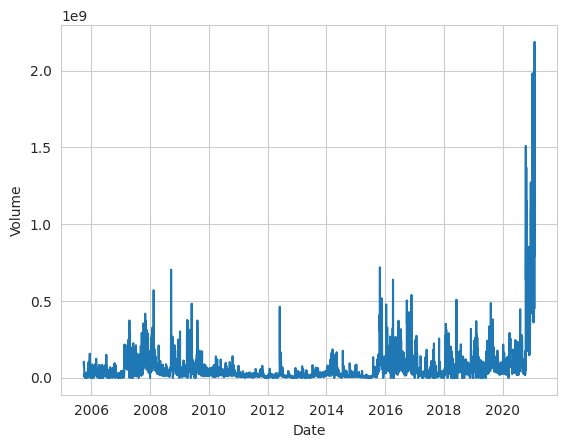

In [11]:
sns.lineplot(x = 'Date', y = 'Volume', data = df)

<Axes: xlabel='Date', ylabel='Value'>

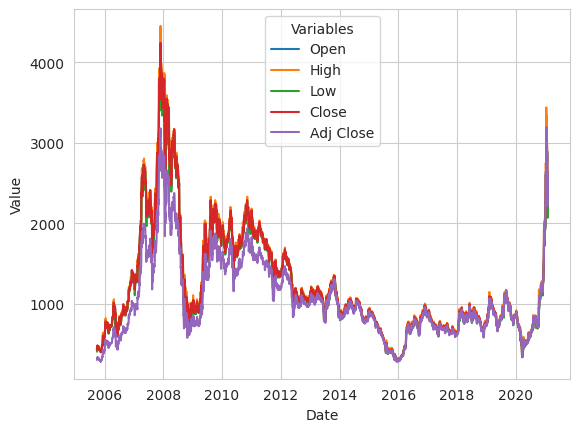

In [12]:
data = pd.melt(df.drop("Volume", axis = 1),
               id_vars = ['Date'],
               value_name = 'Value',
               var_name = 'Variables')

sns.lineplot(x = 'Date', y = 'Value', hue = 'Variables', data = data)

<Axes: >

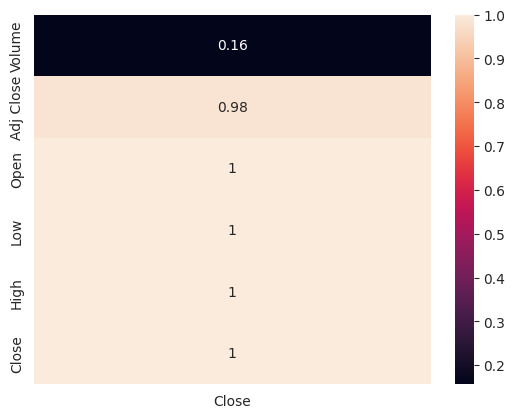

In [13]:
corr = df.corr(numeric_only = True)[['Close']].sort_values(by = "Close")
sns.heatmap(corr, annot = True)

There are a few things noted here:
*   To predict Close, it is not necessary to use High, Low, or Open. They are all identical. We can use previous values of Adj. Close, Volume, and Close instead.
*   Volume has scaling issues, with need to do MinMaxScaling / StandardScaling to fix it.
*   There are no missing values, duplicated values, or outliers that need to be fixed.
*   Make sure that the data is sorted by date, we don't want our windows to be wrongly ordered.


# 2. Data Preprocessing

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_dropped = df.drop(["High", "Low", "Open", "Date"], axis = 1).dropna()
df_scaled = pd.DataFrame(scaler.fit_transform(df_dropped),
                         columns = ['Close', 'Adj Close', 'Volume'])
df_clean = df_scaled.copy()
df_clean['Date'] = df['Date']

df_clean.head()

,Close,Adj Close,Volume,Date
0,0.036812,0.008410,0.034839,2005-09-29
1,0.043184,0.014515,0.048245,2005-09-30
2,0.046370,0.017567,0.027308,2005-10-03
3,0.047432,0.018584,0.025718,2005-10-04
4,0.049556,0.020619,0.014323,2005-10-05


In [15]:
def split(df):
  x = []
  y = []
  for i in range(WINDOW_SIZE, len(df)):
    x.append(df.iloc[i - WINDOW_SIZE:i, :])
    y.append(df['Close'].iloc[i:i+HORIZON])
  return np.array(x), np.array(y)

x, y = split(df_clean.drop("Date", axis = 1))

In [16]:
print(f"Sample of a single x window:\n{x[0]}\n")
print(f"Sample of a single y window:\n{y[0]}")

Sample of a single x window:
[[0.03681223 0.00841028 0.03483894]
 [0.04318393 0.01451478 0.04824451]
 [0.04636977 0.01756702 0.02730793]
 [0.04743172 0.01858443 0.02571815]
 [0.04955562 0.02061927 0.01432295]]

Sample of a single y window:
[0.04530783]


#3. Splitting the Training Data

In [17]:
print(f"x: {len(x)}")
print(f"y: {len(y)}")

x: 3802
y: 3802


In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, shuffle = False)

print(f"Training: {len(x_train)}")
print(f"Validation: {len(x_val)}")
print(f"Testing: {len(x_test)}")

Training: 3041
Validation: 380
Testing: 381


#4. Creating the Models

### MODEL 1: BASE LSTM

In [19]:
from keras.layers import LSTM, Bidirectional, Dense

# Base Model 1: Bidirectional LSTM
INPUT_SHAPE = (WINDOW_SIZE, 3)

inputs = keras.Input(INPUT_SHAPE)
lstm_1 = Bidirectional(LSTM(64, return_sequences = True))(inputs)
lstm_2 = Bidirectional(LSTM(64, return_sequences = True))(lstm_1)
lstm_3 = Bidirectional(LSTM(32, return_sequences = False))(lstm_2)

dense_1 = Dense(16)(lstm_3)

outputs = Dense(1)(dense_1)

base_lstm = keras.Model(inputs, outputs)

In [20]:
base_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 3)]            0         
                                                                 
 bidirectional (Bidirection  (None, 5, 128)            34816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 128)            98816     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                             

In [21]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 25,
        verbose = 1,
        restore_best_weights = True
    )
]

In [22]:
base_lstm.compile(optimizer = 'adam',
                  loss = 'mae',
                  metrics = [keras.metrics.R2Score()])

In [23]:
base_lstm_results = base_lstm.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 100,
    callbacks = callbacks,
    batch_size = 128
)

Epoch 1/100
24/24 [==============================] - 29s 375ms/step - loss: 0.0715 - r2_score: 0.5761 - val_loss: 0.0193 - val_r2_score: 0.1524
Epoch 2/100
24/24 [==============================] - 2s 95ms/step - loss: 0.0165 - r2_score: 0.9803 - val_loss: 0.0068 - val_r2_score: 0.8594
Epoch 3/100
24/24 [==============================] - 2s 95ms/step - loss: 0.0126 - r2_score: 0.9870 - val_loss: 0.0066 - val_r2_score: 0.8626
Epoch 4/100
24/24 [==============================] - 2s 100ms/step - loss: 0.0111 - r2_score: 0.9889 - val_loss: 0.0064 - val_r2_score: 0.8705
Epoch 5/100
24/24 [==============================] - 2s 92ms/step - loss: 0.0109 - r2_score: 0.9896 - val_loss: 0.0066 - val_r2_score: 0.8656
Epoch 6/100
24/24 [==============================] - 4s 150ms/step - loss: 0.0103 - r2_score: 0.9903 - val_loss: 0.0055 - val_r2_score: 0.8958
Epoch 7/100
24/24 [==============================] - 3s 117ms/step - loss: 0.0103 - r2_score: 0.9903 - val_loss: 0.0079 - val_r2_score: 0.8218
E

### MODEL 2: LSTM + Attention

In [24]:
from keras_self_attention import SeqSelfAttention
from keras.layers import GlobalMaxPooling1D
# Base Model 2: Bidirectional LSTM + Attention
INPUT_SHAPE = (WINDOW_SIZE, 3)

inputs = keras.Input(INPUT_SHAPE)
lstm_1 = Bidirectional(LSTM(64, return_sequences = True))(inputs)
lstm_2 = Bidirectional(LSTM(64, return_sequences = True))(lstm_1)
lstm_3 = Bidirectional(LSTM(32, return_sequences = True))(lstm_2)
attn = SeqSelfAttention(
    units = 32,
    kernel_initializer = keras.initializers.GlorotNormal(seed = GLOBAL_SEED),
    attention_activation = 'tanh',
)(lstm_3)

pooling = GlobalMaxPooling1D()(attn)
dense_1 = Dense(16)(pooling)
outputs = Dense(1)(dense_1)

attn_lstm = keras.Model(inputs, outputs)

In [25]:
attn_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 3)]            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 5, 128)            34816     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 5, 128)            98816     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 5, 64)             41216     
 onal)                                                           
                                                                 
 seq_self_attention (SeqSel  (None, 5, 64)             4161      
 fAttention)                                               

In [26]:
attn_lstm.compile(optimizer = 'adam',
                  loss = 'mae',
                  metrics = [keras.metrics.R2Score()])

In [27]:
attn_lstm_results = attn_lstm.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 100,
    callbacks = callbacks,
    batch_size = 128
)

Epoch 1/100
24/24 [==============================] - 19s 197ms/step - loss: 0.0990 - r2_score: 0.3163 - val_loss: 0.0422 - val_r2_score: -2.4453
Epoch 2/100
24/24 [==============================] - 3s 126ms/step - loss: 0.0217 - r2_score: 0.9702 - val_loss: 0.0097 - val_r2_score: 0.7585
Epoch 3/100
24/24 [==============================] - 1s 60ms/step - loss: 0.0145 - r2_score: 0.9841 - val_loss: 0.0063 - val_r2_score: 0.8673
Epoch 4/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0127 - r2_score: 0.9874 - val_loss: 0.0058 - val_r2_score: 0.8881
Epoch 5/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0112 - r2_score: 0.9893 - val_loss: 0.0057 - val_r2_score: 0.8898
Epoch 6/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0103 - r2_score: 0.9904 - val_loss: 0.0055 - val_r2_score: 0.8970
Epoch 7/100
24/24 [==============================] - 1s 60ms/step - loss: 0.0103 - r2_score: 0.9903 - val_loss: 0.0057 - val_r2_score: 0.8943
Ep

Sequential self-attention is added on the second model.
In its essence, sequential self-attention takes the sequence, and sets weights to specific values that needs to be "paid attention to". Self-attention effectively makes such that RNN's long sequences and vanishing/explosive gradient issues can be mitigated by only attending to the needed inputs only.

#5. Evaluation

In [28]:
def plot_training_graphs(result1, result2, name1, name2):
  fig, axes = plt.subplots(1, 2, figsize = (12, 4))
  graph1 = pd.DataFrame(result1.history)
  graph2 = pd.DataFrame(result2.history)
  for col in graph1.columns:
    graph1.rename(columns = {col:name1+'_'+col.upper()}, inplace = True)
  for col in graph2.columns:
    graph2.rename(columns = {col:name2+'_'+col.upper()}, inplace = True)

  graph1.loc[:, [f"{name1}_LOSS", f"{name1}_VAL_LOSS"]].plot(ax = axes[0], title = "Train/Val Loss Plot")
  graph1.loc[:, [f"{name1}_R2_SCORE", f"{name1}_VAL_R2_SCORE"]].plot(ax = axes[1], title = "Train/Val R2 Score Plot")

  graph2.loc[:, [f"{name2}_LOSS", f"{name2}_VAL_LOSS"]].plot(ax = axes[0], title = "Train/Val Loss Plot")
  graph2.loc[:, [f"{name2}_R2_SCORE", f"{name2}_VAL_R2_SCORE"]].plot(ax = axes[1], title = "Train/Val R2 Score Plot")

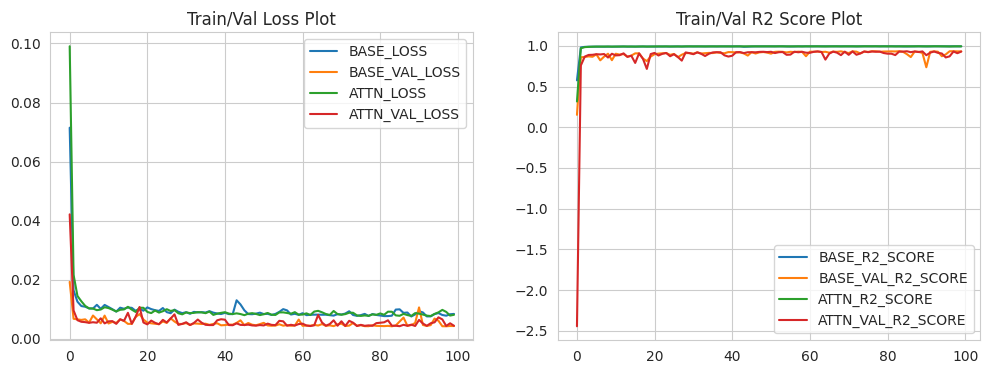

In [29]:
plot_training_graphs(base_lstm_results, attn_lstm_results, "BASE", "ATTN")

In [30]:
base_preds = base_lstm.predict(x_test)
attn_preds = attn_lstm.predict(x_test)

12/12 [==============================] - 3s 9ms/step


In [31]:
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error
def evaluate(y_pred, y_true):
  print(f"EVS: {explained_variance_score(y_true, y_pred)}")
  print(f"R^2: {r2_score(y_true, y_pred)}")
  print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

In [32]:
evaluate(base_preds, y_test)

EVS: 0.9767882798389289
R^2: 0.9765880072595351
MAE: 0.00967724730843415


In [33]:
evaluate(attn_preds, y_test)

EVS: 0.9764871870945383
R^2: 0.9763027949733611
MAE: 0.00966841344353168


From the results above, there is not much of a differencce between the two models. Both achieve really high scores already even with such a simple model. To evaluate we use R^2 / EVS since they are both very similar metrics that shows how much of the data can be explained by our model, which is a very important metric to see. MAE is also given to see how large of a difference we have. (Note that this is still scaled to 0 - 1).

The most probably reason that the Self Attention does not provide much difference, is the fact that all data is equally important, and the window size is too small to make a difference anyway. If we have a larger window size, the result might be completely different.

Nonetheless, from the results, we can see both models have very good results. An EVS and R^2 score of 0.97 means 97% of the data can be explained with the model. An MAE of 0.009 means the average mean score is very small.

From the loss plots, we can also see that the model has plateaud, but already reached a very satistfying result.

All the points above show that both the models are really good, although a slight difference exists between them. Self-attention doesn't seem to provide much effect.

In [34]:
def plotdiff(preds, y_true, title):
  df = pd.DataFrame(preds, columns = ['Prediction'])
  df['Ground Truth'] = y_true
  df['Abs. Diff'] = abs(df['Ground Truth'] - df['Prediction'])

  df['Ground Truth'].plot(legend = True)
  df['Prediction'].plot(legend = True)
  df['Abs. Diff'].plot(legend = True)

  plt.title(title)

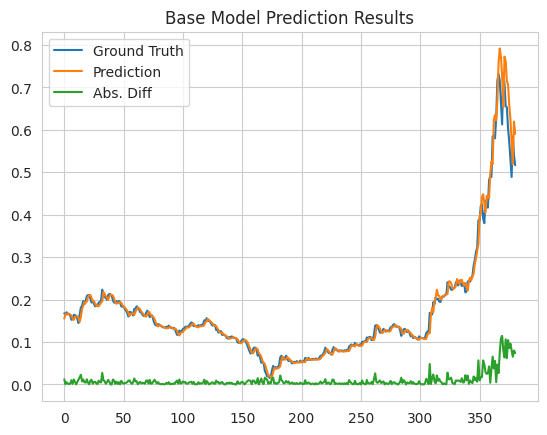

In [35]:
plotdiff(base_preds, y_test, "Base Model Prediction Results")

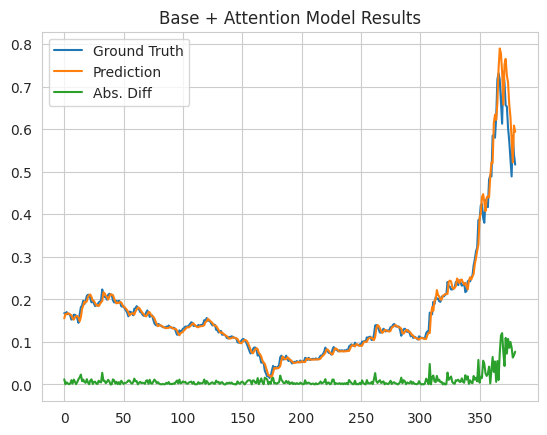

In [36]:
plotdiff(attn_preds, y_test, "Base + Attention Model Results")

From the graphs above, both of our models are capable to predict the data completely well, with very small differences between the predicted and real data. An R^2 of above 0.97 shows that almost 97% of the data is modelled correctly by our model.